In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("/app/")
from visualizations.scripts.drawer import russia_plots_n
from data_builders.scripts.loaders import multi_var_nc
from tqdm.notebook import tqdm
from scripts.file_readers import df_reader
from scripts.data_describers import station_describer
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import pathlib
import glob

### Recalculate one file

### Stupid debug

In [14]:
# find out which files are cursed
files = glob.glob('../geo_data/meteorology/meteo_ru/*.csv')


def data_reader(csv_path):
    f = pd.read_csv(csv_path, index_col='date')
    f.index = pd.to_datetime(f.index)
    f = f.loc['2008':'2020', :]
    f = f.applymap(
        lambda x: pd.to_numeric(x, errors='coerce'))
    return f


nan_files = {}
empty_files = {}
partial_nans = {}
nan_lens = {}
comp_files = glob.glob('../geo_data/meteorology/station_vs_reanalysis/*.csv')
for f in comp_files:
    s_id = f.split('/')[-1][:-4]
    df = data_reader(f)
    if df.empty:
        empty_files[s_id] = f
    elif df.isna().sum().sum() > 3000:
        nan_files[s_id] = f
    elif df[['prcp']].isna().sum().sum() > 0:
        nan_lens[s_id] = {f'{s_id}': df[['prcp']].isna().sum().sum()}

In [92]:
from scripts.file_readers import station_lat_lon

gdf_file = gpd.read_file("../geo_data/great_db/meteo_stations.gpkg")
gdf_file["gauge_id"] = gdf_file["gauge_id"].astype(str)
gdf_file = gdf_file.set_index("gauge_id")

meteo_lon, meteo_lat = station_lat_lon(
    gdf_file.loc[f"{station_id}", "geometry"])
meteo_dict = {
    "era5_land": multi_var_nc(
        path_to_nc="../geo_data/meteorology/era5-land/russia", file_extension="nc"
    ),
    "era5": multi_var_nc(
        path_to_nc="../geo_data/meteorology/era5/russia", file_extension="nc"
    ),
    "gpcp": multi_var_nc(
        path_to_nc="../geo_data/meteorology/gpcp_year_new", file_extension="nc"
    ),
    "imerg": multi_var_nc(
        path_to_nc="../geo_data/meteorology/imerg_year_new", file_extension="nc"
    ),
    "mswep": multi_var_nc(
        path_to_nc="../geo_data/meteorology/mswep_new", file_extension="nc"
    ),
}

In [ ]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("error")
    described_df_1day = pd.DataFrame()
    for file in tqdm(files, desc="Comparison results..."):
        test_df = df_reader(file)
        station_id = file.split("/")[-1][:-4]
        col_modifier = ["era5_land", "era5", "mswep", "imerg", "gpcp"]
        for col in col_modifier:
            result = station_describer(
                test_df,
                frequency="1d",
                modifier=col,
                prcp_station="prcp",
                prcp_meteo=f"{col}_prcp",
            )
            for key, val in result.items():
                described_df_1day.loc[station_id, key] = val

### Get daily RMSE, daily absolute and correlation coefficient for station

### Plot results

In [7]:
geometry_path = pathlib.Path("/Users/dmbrmv/Development/geo_data/geometry/")
great_db_path = pathlib.Path("/Users/dmbrmv/Development/geo_data/great_db")
meteo_path = pathlib.Path(
    "/Users/dmbrmv/Development/geo_data/station_vs_reanalysis")
files = list(meteo_path.glob("*.csv"))

In [16]:
station_geometry = gpd.read_file(f"{great_db_path}/meteo_stations.gpkg")
station_geometry["gauge_id"] = station_geometry["gauge_id"].astype(str)
station_geometry = station_geometry.set_index("gauge_id")

basemap_data = gpd.read_file(f"{geometry_path}/basemap_2023.gpkg")
basin_districts = gpd.read_file(f"{geometry_path}/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

In [12]:
def metric_description(
    station_geom: gpd.GeoDataFrame,
    basemap: gpd.GeoDataFrame,
    basin_districts: gpd.GeoDataFrame,
    res_df: pd.DataFrame,
    metric_column: str,
):
    res_df = res_df.loc[:, [
        c for c in res_df.columns if f"{metric_column}" in c]]
    metric_cols = res_df.columns
    geom_example = station_geom.join(res_df)

    points_in_russia = gpd.sjoin(
        geom_example[["geometry"]].set_crs(epsg=4326, allow_override=True),
        basemap[["geometry"]].set_crs(epsg=4326, allow_override=True),
    ).index

    geom_example = geom_example.loc[points_in_russia, :]

    # give ugms some shine
    for i, geom in enumerate(basin_districts["geometry"]):
        ugms_part = geom_example.loc[
            [geom.intersects(gage_point) for gage_point in geom_example["geometry"]], :
        ]

        basin_districts.loc[i, metric_cols] = ugms_part[metric_cols].median()

    return (geom_example, basin_districts, metric_cols)

### Precipitation

#### One day

In [15]:
def res_describer(freq: str):
    described_df = pd.DataFrame()
    for file in tqdm(files, desc=f"Comparison results for {freq} span"):
        test_df = df_reader(file)
        station_id = file.stem
        col_modifier = ["era5_land", "era5", "mswep", "gpcp"]
        for col in col_modifier:
            result = station_describer(
                test_df,
                frequency=f"{freq}",
                modifier=col,
                prcp_station="prcp",
                prcp_meteo=f"{col}_prcp",
            )
            for key, val in result.items():
                described_df.loc[station_id, key] = val

    (pearson_day_point, pearson_1day_bas, pearson_1day_cols) = metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=described_df,
        metric_column="pearson",
    )
    (mean_day_point, mean_1day_bas, mean_1day_cols) = metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=described_df,
        metric_column="mean",
    )

    res_df_cols = [
        (i.split("_")[0], int(re.match(r"[\d]+", f"{freq}")[0]))
        if len(i.split("_")) == 2
        else ("_".join(i.split("_")[:2]), int(re.match(r"[\d]+", f"{freq}")[0]))
        for i in pearson_1day_cols
    ]

    mean_df = mean_day_point[mean_1day_cols]
    mean_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    mean_df = mean_df.mean().to_frame().T
    mean_df.index = ["∆, мм"]

    pearson_df = pearson_day_point[pearson_1day_cols]
    pearson_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    pearson_df = pearson_df.mean().to_frame().T
    pearson_df.index = ["r"]

    return {"mean_df": mean_df, "pearson_df": pearson_df}

In [14]:
freq = "1d"
described_df = pd.DataFrame()
for file in tqdm(files, desc=f"Comparison results for {freq} span"):
    test_df = df_reader(file)
    station_id = file.stem
    col_modifier = ["era5_land", "era5", "mswep", "gpcp"]
    for col in col_modifier:
        result = station_describer(
            test_df,
            frequency=f"{freq}",
            modifier=col,
            prcp_station="prcp",
            prcp_meteo=f"{col}_prcp",
        )
        for key, val in result.items():
            described_df.loc[station_id, key] = val

(pearson_day_point, pearson_1day_bas, pearson_1day_cols) = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df,
    metric_column="pearson",
)

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [30]:
fullfillment = list()
for s_id in pearson_day_point.index:
    file = pd.read_csv(
        f'../geo_data/meteorology/station_vs_reanalysis/{s_id}.csv')
    file = file[['t_min', 't_max', 'prcp']]
    fullfillment.append((file[['t_min', 't_max', 'prcp']].isna().sum(
    ) / len(file[['t_min', 't_max', 'prcp']]) * 100).mean())

In [37]:
file = pd.read_csv(f"../geo_data/meteorology/station_vs_reanalysis/{s_id}.csv")

In [16]:
one_day_prcp = res_describer(freq="1d")

ten_day_prcp = res_describer(freq="10d")

one_month_prcp = res_describer(freq="30d")

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

Comparison results for 10d span:   0%|          | 0/588 [00:00<?, ?it/s]

Comparison results for 30d span:   0%|          | 0/588 [00:00<?, ?it/s]

In [19]:
mean_df = pd.concat(
    [one_day_prcp["mean_df"], ten_day_prcp["mean_df"], one_month_prcp["mean_df"]],
    axis=1,
)
mean_df.columns = pd.MultiIndex.from_tuples(
    mean_df.columns, names=["Датасет", "Интервал, дней"], sortorder=None
)
mean_df.sort_index(
    inplace=True, axis=1, level=["Датасет", "Интервал, дней"], ascending=True
)

pearson_df = pd.concat(
    [
        one_day_prcp["pearson_df"],
        ten_day_prcp["pearson_df"],
        one_month_prcp["pearson_df"],
    ],
    axis=1,
)
pearson_df.columns = pd.MultiIndex.from_tuples(
    pearson_df.columns, names=["Датасет", "Интервал, дней"], sortorder=None
)
pearson_df.sort_index(
    inplace=True, axis=1, level=["Датасет", "Интервал, дней"], ascending=True
)

In [20]:
pd.options.display.float_format = "{:,.2f}".format
res_df = pd.concat([mean_df, pearson_df])

In [11]:
res_df.to_csv("./precipitation_table.csv")

In [21]:
freq = "1d"
described_df_1day = pd.DataFrame()
for file in tqdm(files, desc=f"Comparison results for {freq} span"):
    test_df = df_reader(file)
    station_id = file.stem
    col_modifier = ["era5_land", "era5", "mswep", "gpcp"]
    for col in col_modifier:
        result = station_describer(
            test_df,
            frequency=f"{freq}",
            modifier=col,
            prcp_station="prcp",
            prcp_meteo=f"{col}_prcp",
        )
        for key, val in result.items():
            described_df_1day.loc[station_id, key] = val

pearson_1day_point, pearson_1day_bas, pearson_1day_cols = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df_1day,
    metric_column="pearson",
)
mean_1day_point, mean_1day_bas, mean_1day_cols = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=described_df_1day,
    metric_column="mean",
)

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

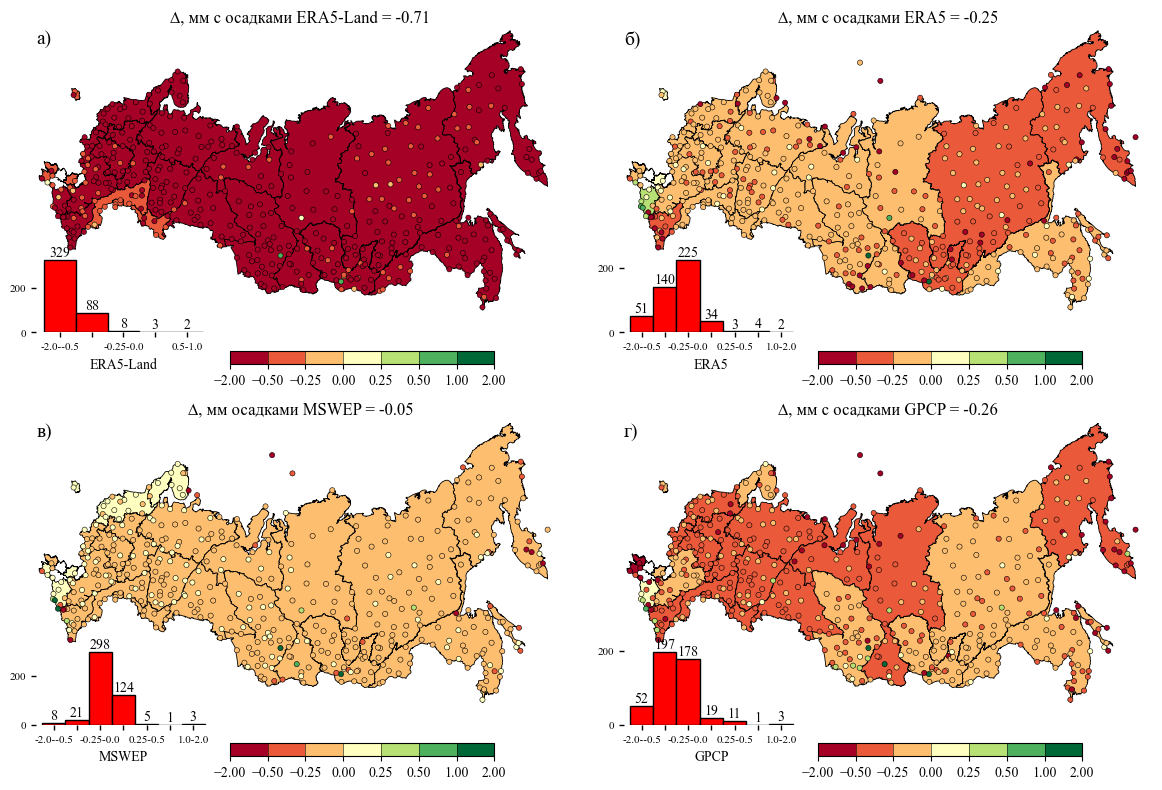

In [24]:
metric_name = "∆, мм"
res_dict = mean_1day_point[mean_1day_cols].mean().to_dict()
e5l_mean, e5_mean, mswp_mean, gpcp_mean = res_dict.values()

meteo_nse = russia_plots_n(
    gdf_to_plot=mean_1day_point,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=2,
    list_of_limits=[-2, -0.5, -0.25, 0.0, 0.25, 0.5, 1, 2],
    label_list=["а)", "б)", "в)", "г)", "д)", "е)"],
    columns_from_gdf=mean_1day_cols,
    with_histogram=True,
    title_text=[
        f"{metric_name} с осадками ERA5-Land = {e5l_mean:.2f}",
        f"{metric_name} с осадками ERA5 = {e5_mean:.2f}",
        f"{metric_name} осадками MSWEP = {mswp_mean:.2f}",
        f"{metric_name} с осадками GPCP = {gpcp_mean:.2f}",
    ],
    hist_name=["ERA5-Land", "ERA5", "MSWEP", "GPCP"],
    ugms=True,
    ugms_gdf=mean_1day_bas,
)
meteo_nse.savefig("./images/precipitation_daily_diff.png", dpi=600, bbox_inches="tight")


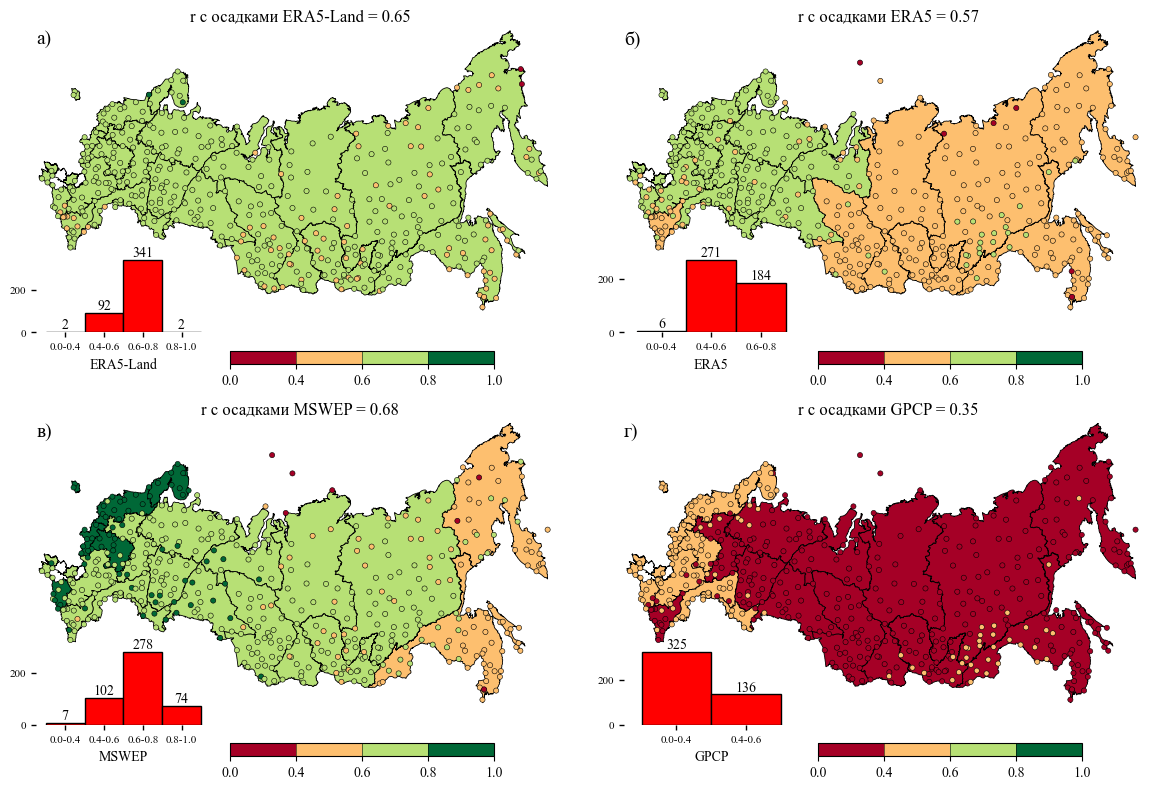

In [25]:
metric_name = "r"
res_dict = pearson_1day_point[pearson_1day_cols].mean().to_dict()
e5l_mean, e5_mean, mswp_mean, gpcp_mean = res_dict.values()

meteo_nse = russia_plots_n(
    gdf_to_plot=pearson_1day_point,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=2,
    list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
    label_list=["а)", "б)", "в)", "г)", "д)", "е)"],
    columns_from_gdf=pearson_1day_cols,
    with_histogram=True,
    title_text=[
        f"{metric_name} с осадками ERA5-Land = {e5l_mean:.2f}",
        f"{metric_name} с осадками ERA5 = {e5_mean:.2f}",
        f"{metric_name} с осадками MSWEP = {mswp_mean:.2f}",
        f"{metric_name} с осадками GPCP = {gpcp_mean:.2f}",
    ],
    hist_name=["ERA5-Land", "ERA5", "MSWEP", "GPCP"],
    ugms=True,
    ugms_gdf=pearson_1day_bas,
)
meteo_nse.savefig("./images/precipitation_daily_r.png", dpi=600, bbox_inches="tight")

### Temperature

In [ ]:
df_t2m_max = pd.DataFrame()
freq = "1d"
for file in tqdm(files, desc=f"Comparison results for {freq} span"):
    test_df = df_reader(file)
    station_id = file.stem
    col_modifier = ["era5_land", "era5"]
    for col in col_modifier:
        result = station_describer(
            test_df,
            frequency=f"{freq}",
            modifier=col,
            prcp_station="t_max",
            prcp_meteo=f"{col}_2m_max",
        )
        for key, val in result.items():
            df_t2m_max.loc[station_id, key] = val

df_t2m_min = pd.DataFrame()
for file in tqdm(files, desc=f"Comparison results for {freq} span"):
    test_df = df_reader(file)
    station_id = file.stem
    col_modifier = ["era5_land", "era5"]
    for col in col_modifier:
        result = station_describer(
            test_df,
            frequency=f"{freq}",
            modifier=col,
            prcp_station="t_min",
            prcp_meteo=f"{col}_2m_min",
        )
        for key, val in result.items():
            df_t2m_min.loc[station_id, key] = val

In [13]:
def res_describer(
    freq: str,
    col_modifier: list,
    mean_symbol: str,
    station_code: str,
    era_code: str,
    with_temp: str = "",
):
    described_df = pd.DataFrame()
    for file in tqdm(files, desc=f"Comparison results for {freq} span"):
        test_df = df_reader(file)
        station_id = file.stem
        # col_modifier = ['era5_land', 'era5', 'mswep', 'gpcp']
        for col in col_modifier:
            result = station_describer(
                test_df,
                frequency=f"{freq}",
                modifier=col,
                prcp_station=f"{station_code}",
                prcp_meteo=f"{col}_{era_code}",
            )
            for key, val in result.items():
                described_df.loc[station_id, key] = val

    (pearson_day_point, pearson_1day_bas, pearson_1day_cols) = metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=described_df,
        metric_column="pearson",
    )
    (mean_day_point, mean_1day_bas, mean_1day_cols) = metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=described_df,
        metric_column="mean",
    )
    if with_temp:
        res_df_cols = [
            (f'{i.split("_")[0]} {with_temp}', int(
                re.match(r"[\d]+", f"{freq}")[0]))
            if len(i.split("_")) == 2
            else (
                f'{"_".join(i.split("_")[:2])} {with_temp}',
                int(re.match(r"[\d]+", f"{freq}")[0]),
            )
            for i in pearson_1day_cols
        ]
    else:
        res_df_cols = [
            (i.split("_")[0], int(re.match(r"[\d]+", f"{freq}")[0]))
            if len(i.split("_")) == 2
            else ("_".join(i.split("_")[:2]), int(re.match(r"[\d]+", f"{freq}")[0]))
            for i in pearson_1day_cols
        ]

    mean_df = mean_day_point[mean_1day_cols]
    mean_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    mean_df = mean_df.mean().to_frame().T
    mean_df.index = [f"∆, {mean_symbol}"]

    pearson_df = pearson_day_point[pearson_1day_cols]
    pearson_df.columns = pd.MultiIndex.from_tuples(res_df_cols)
    pearson_df = pearson_df.mean().to_frame().T
    pearson_df.index = ["r"]

    return {"mean_df": mean_df, "pearson_df": pearson_df}

In [14]:
one_day_t_max = res_describer(
    freq="1d",
    col_modifier=["era5_land", "era5"],
    station_code="t_max",
    era_code="2m_max",
    with_temp="t макс.",
    mean_symbol="°",
)
ten_day_t_max = res_describer(
    freq="10d",
    col_modifier=["era5_land", "era5"],
    station_code="t_max",
    era_code="2m_max",
    with_temp="t макс.",
    mean_symbol="°",
)
one_day_t_min = res_describer(
    freq="1d",
    col_modifier=["era5_land", "era5"],
    station_code="t_min",
    era_code="2m_min",
    with_temp="t мин.",
    mean_symbol="°",
)
ten_day_t_min = res_describer(
    freq="10d",
    col_modifier=["era5_land", "era5"],
    station_code="t_min",
    era_code="2m_min",
    with_temp="t мин.",
    mean_symbol="°",
)

Comparison results for 1d span:   0%|          | 0/588 [00:00<?, ?it/s]

/Users/dmbrmv/miniconda3/envs/geo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dmbrmv/miniconda3/envs/geo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dmbrmv/miniconda3/envs/geo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/dmbrmv/miniconda3/envs/geo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.

NameError: name 'station_geometry' is not defined

In [31]:
mean_df = pd.concat(
    [
        one_day_t_max["mean_df"],
        one_day_t_min["mean_df"],
        ten_day_t_max["mean_df"],
        ten_day_t_min["mean_df"],
    ],
    axis=1,
)
mean_df.columns = pd.MultiIndex.from_tuples(
    mean_df.columns, names=["Датасет", "Интервал, дней"], sortorder=None
)
mean_df.sort_index(
    inplace=True, axis=1, level=["Датасет", "Интервал, дней"], ascending=True
)
pearson_df = pd.concat(
    [
        one_day_t_max["pearson_df"],
        one_day_t_min["pearson_df"],
        ten_day_t_max["pearson_df"],
        ten_day_t_min["pearson_df"],
    ],
    axis=1,
)
pearson_df.columns = pd.MultiIndex.from_tuples(
    pearson_df.columns, names=["Датасет", "Интервал, дней"], sortorder=None
)
pearson_df.sort_index(
    inplace=True, axis=1, level=["Датасет", "Интервал, дней"], ascending=True
)

pd.options.display.float_format = "{:,.2f}".format
res_df = pd.concat([mean_df, pearson_df])
res_df

Датасет        era5 t макс.       era5 t мин.       era5_land t макс.        \
Интервал, дней           1     10          1     10                1     10   
∆, °                   1.09 10.88       -0.24 -2.37              1.46 14.63   
r                      0.99  1.00        0.97  1.00              0.99  1.00   

Датасет        era5_land t мин.        
Интервал, дней               1     10  
∆, °                      -0.88 -8.75  
r                          0.97  0.99

In [111]:
basin_districts

,name1,geometry
0,лнр,"MULTIPOLYGON (((36.22324 46.56331, 36.22304 46..."
1,днр,"MULTIPOLYGON (((32.55747 46.06686, 32.55777 46..."
2,херсон,"MULTIPOLYGON (((37.87218 49.23760, 37.87269 49..."
3,сон,"MULTIPOLYGON (((38.33152 50.07360, 38.33233 50..."
4,Двинско-Печорский,"MULTIPOLYGON (((38.85546 59.40897, 38.85640 59..."
5,Балтийский,"MULTIPOLYGON (((30.90941 55.00907, 30.90016 55..."
6,Ангаро-Байкальский,"MULTIPOLYGON (((111.15035 50.81063, 111.14815 ..."
7,Баренцево-Беломорский,"MULTIPOLYGON (((36.50054 63.25648, 36.50115 63..."
8,Амурский,"MULTIPOLYGON (((142.75728 46.63792, 142.76484 ..."
9,Ленский. обрез,"MULTIPOLYGON (((117.66208 54.63161, 117.66208 ..."


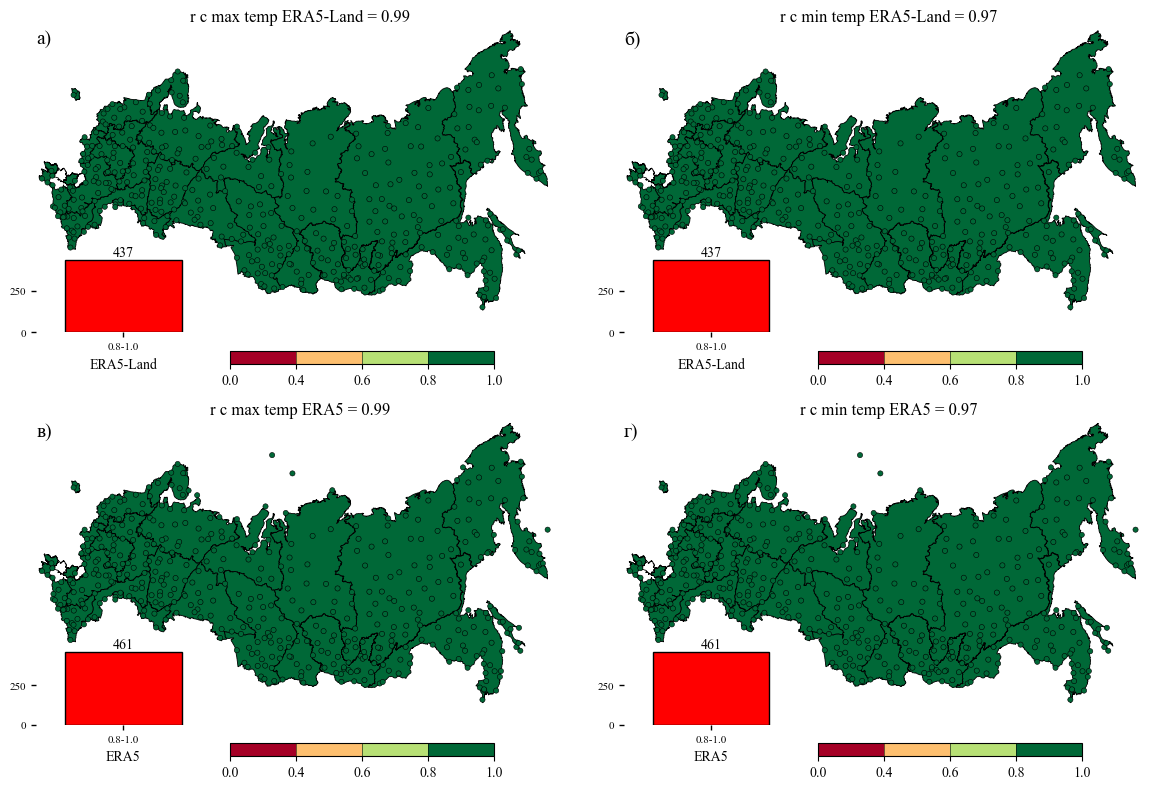

In [122]:
# temperature
(pearson_day_point_max, pearson_1day_bas_max, pearson_1day_cols_max) = (
    metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=df_t2m_max,
        metric_column="pearson",
    )
)
temp_bas_max = pearson_1day_bas_max[
    ["name1", "geometry", "era5_land_pearson", "era5_pearson"]
]
temp_bas_max = temp_bas_max.rename(
    columns={i: f"{i}_max" for i in ["era5_land_pearson", "era5_pearson"]}
).set_crs(epsg=4326)
# temperature
(pearson_day_point_min, pearson_1day_bas_min, pearson_1day_cols_min) = (
    metric_description(
        station_geom=station_geometry,
        basemap=basemap_data,
        basin_districts=basin_districts,
        res_df=df_t2m_min,
        metric_column="pearson",
    )
)
temp_bas_min = pearson_1day_bas_min[
    ["name1", "geometry", "era5_land_pearson", "era5_pearson"]
]
temp_bas_min = temp_bas_min.rename(
    columns={i: f"{i}_min" for i in ["era5_land_pearson", "era5_pearson"]}
).set_crs(epsg=4326)

metric_name = "r"
res_dict_min = pearson_day_point_min[pearson_1day_cols_min].mean().to_dict()
res_dict_max = pearson_day_point_max[pearson_1day_cols_max].mean().to_dict()
one_day_t_max_era5l, one_day_t_max_era5 = res_dict_max.values()
one_day_t_min_era5l, one_day_t_min_era5 = res_dict_min.values()

pearson_day_point_min = pearson_day_point_min.rename(
    columns={i: f"{i}_min" for i in pearson_1day_cols_min}
)
pearson_day_point_max = pearson_day_point_max.rename(
    columns={i: f"{i}_max" for i in pearson_1day_cols_max}
)

pearson_temp_df = pearson_day_point_max.combine_first(pearson_day_point_min)
pearson_temp_df = pearson_temp_df.set_crs(epsg=4326)


pearson_temp_bas_df = temp_bas_max.combine_first(temp_bas_min)
pearson_temp_bas_df = pearson_temp_bas_df.set_crs(epsg=4326)

meteo_nse = russia_plots_n(
    gdf_to_plot=pearson_temp_df,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=2,
    list_of_limits=[0.0, 0.4, 0.6, 0.8, 1.0],
    label_list=["а)", "б)", "в)", "г)"],
    columns_from_gdf=pearson_temp_df.columns[:4],
    with_histogram=True,
    title_text=[
        f"{metric_name} с max temp ERA5-Land = {one_day_t_max_era5l:.2f}",
        f"{metric_name} с min temp ERA5-Land = {one_day_t_min_era5l:.2f}",
        f"{metric_name} с max temp ERA5 = {one_day_t_max_era5:.2f}",
        f"{metric_name} с min temp ERA5 = {one_day_t_min_era5:.2f}",
    ],
    hist_name=["ERA5-Land", "ERA5-Land", "ERA5", "ERA5"],
    ugms=True,
    ugms_gdf=pearson_temp_bas_df,
)
# meteo_nse.savefig("./images/precipitation_daily_r.png", dpi=600, bbox_inches="tight")

In [115]:
df_t2m_max

,df_len,era5_land_r2,era5_land_pearson,era5_land_mae,era5_land_rmse,era5_land_mean,era5_r2,era5_pearson,era5_mae,era5_rmse,era5_mean
32564,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36064,"4,749.00",0.78,0.97,160.76,29.72,4.51,0.80,0.98,159.67,27.47,4.29
31092,"4,740.00",0.91,0.99,71.06,20.04,3.32,0.95,0.99,47.93,11.11,2.01
37385,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27814,"4,749.00",0.98,0.99,35.85,2.89,0.85,0.99,1.00,26.64,1.61,0.34
...,...,...,...,...,...,...,...,...,...,...,...
25954,"1,583.00",NaN,NaN,NaN,NaN,NaN,0.92,0.97,57.85,10.96,1.36
27164,"4,749.00",0.96,0.99,53.39,6.59,1.50,0.98,0.99,40.45,3.63,0.84
25767,"2,070.00",0.56,0.93,309.79,59.37,5.63,0.89,0.95,80.00,15.33,1.54
36055,"4,749.00",0.93,0.98,71.25,13.76,2.73,0.95,0.98,63.97,10.21,2.10


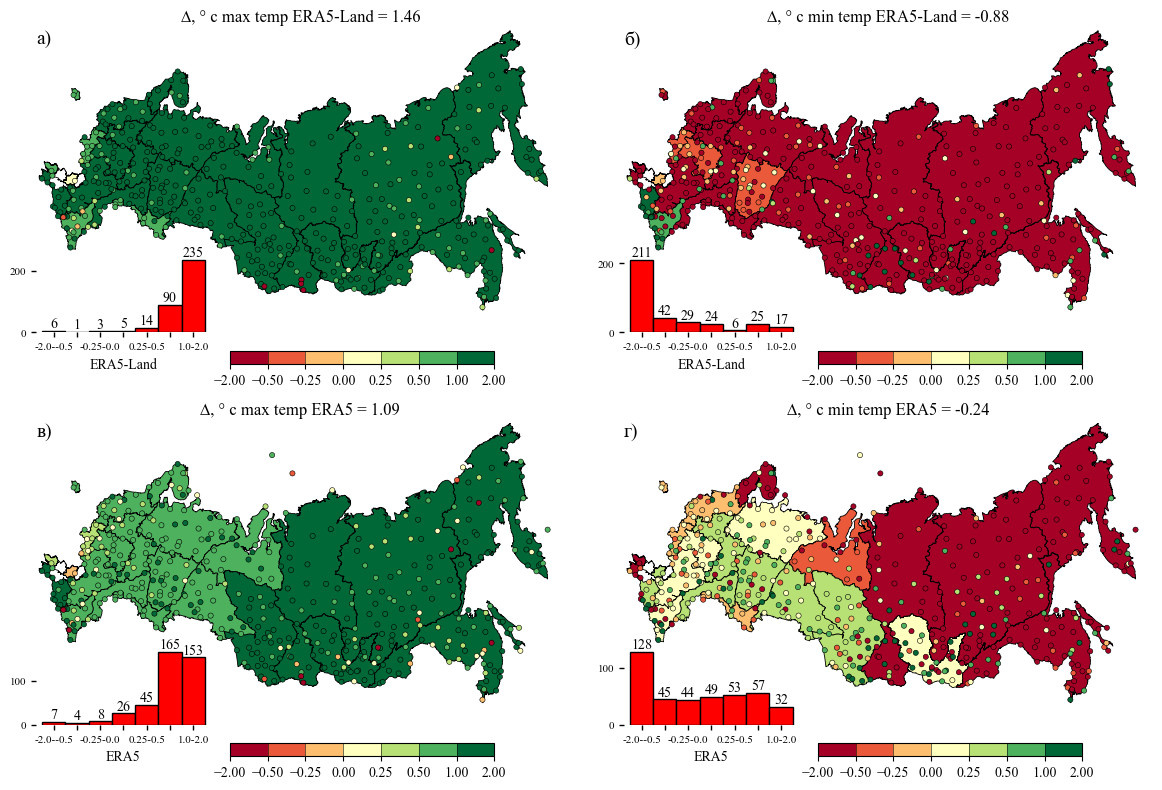

In [18]:
metric_name = "∆, °"
# temperature
(mean_day_point_max, mean_1day_bas_max, mean_1day_cols_max) = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=df_t2m_max,
    metric_column="mean",
)
res_dict_max = mean_day_point_max[mean_1day_cols_max].mean().to_dict()
one_day_t_max_era5l, one_day_t_max_era5 = res_dict_max.values()

temp_bas_max = mean_1day_bas_max[["name1", "geometry", "era5_land_mean", "era5_mean"]]
temp_bas_max = temp_bas_max.rename(
    columns={i: f"{i}_max" for i in ["era5_land_mean", "era5_mean"]}
).set_crs(epsg=4326)


# temperature
(mean_day_point_min, mean_1day_bas_min, mean_1day_cols_min) = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=df_t2m_min,
    metric_column="mean",
)

res_dict_min = mean_day_point_min[mean_1day_cols_min].mean().to_dict()
one_day_t_min_era5l, one_day_t_min_era5 = res_dict_min.values()

temp_bas_min = mean_1day_bas_min[["name1", "geometry", "era5_land_mean", "era5_mean"]]
temp_bas_min = temp_bas_min.rename(
    columns={i: f"{i}_min" for i in ["era5_land_mean", "era5_mean"]}
).set_crs(epsg=4326)


mean_day_point_min = mean_day_point_min.rename(
    columns={i: f"{i}_min" for i in mean_1day_cols_min}
)
mean_day_point_max = mean_day_point_max.rename(
    columns={i: f"{i}_max" for i in mean_1day_cols_max}
)

mean_temp_df = mean_day_point_max.combine_first(mean_day_point_min)
mean_temp_df = mean_temp_df.set_crs(epsg=4326)


mean_temp_bas_df = temp_bas_max.combine_first(temp_bas_min)
mean_temp_bas_df = mean_temp_bas_df.set_crs(epsg=4326)

meteo_nse = russia_plots_n(
    gdf_to_plot=mean_temp_df,
    basemap_data=basemap_data,
    figsize=(15, 8),
    nrows=2,
    ncols=2,
    list_of_limits=[-2, -0.5, -0.25, 0.0, 0.25, 0.5, 1, 2],
    label_list=["а)", "б)", "в)", "г)"],
    columns_from_gdf=mean_temp_df.columns[:4],
    with_histogram=True,
    title_text=[
        f"{metric_name} с max temp ERA5-Land = {one_day_t_max_era5l:.2f}",
        f"{metric_name} с min temp ERA5-Land = {one_day_t_min_era5l:.2f}",
        f"{metric_name} с max temp ERA5 = {one_day_t_max_era5:.2f}",
        f"{metric_name} с min temp ERA5 = {one_day_t_min_era5:.2f}",
    ],
    hist_name=["ERA5-Land", "ERA5-Land", "ERA5", "ERA5"],
    ugms=True,
    ugms_gdf=mean_temp_bas_df,
)
meteo_nse.savefig("./images/temperature_daily_diff.png", dpi=600, bbox_inches="tight")

In [119]:
(mean_day_point_max, mean_1day_bas_max, mean_1day_cols_max) = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=df_t2m_max,
    metric_column="mean",
)

In [120]:
mean_1day_bas_max

,name1,geometry,era5_land_mean,era5_mean
0,лнр,"MULTIPOLYGON (((36.22324 46.56331, 36.22304 46...",NaN,NaN
1,днр,"MULTIPOLYGON (((32.55747 46.06686, 32.55777 46...",0.79,0.50
2,херсон,"MULTIPOLYGON (((37.87218 49.23760, 37.87269 49...",0.17,-0.06
3,сон,"MULTIPOLYGON (((38.33152 50.07360, 38.33233 50...",NaN,NaN
4,Двинско-Печорский,"MULTIPOLYGON (((38.85546 59.40897, 38.85640 59...",1.29,0.85
5,Балтийский,"MULTIPOLYGON (((30.90941 55.00907, 30.90016 55...",1.03,0.67
6,Ангаро-Байкальский,"MULTIPOLYGON (((111.15035 50.81063, 111.14815 ...",1.45,1.66
7,Баренцево-Беломорский,"MULTIPOLYGON (((36.50054 63.25648, 36.50115 63...",1.19,0.77
8,Амурский,"MULTIPOLYGON (((142.75728 46.63792, 142.76484 ...",1.33,1.04
9,Ленский. обрез,"MULTIPOLYGON (((117.66208 54.63161, 117.66208 ...",1.55,1.14


In [ ]:
(mean_day_point, mean_1day_bas, mean_1day_cols) = metric_description(
    station_geom=station_geometry,
    basemap=basemap_data,
    basin_districts=basin_districts,
    res_df=df_t2m_max,
    metric_column="mean",
)

In [2]:
import glob

len(glob.glob("../geo_data/meteorology/station_vs_reanalysis/*.csv"))

588

### Read meteo station geometry

In [5]:
gdf_file = gpd.read_file("../geo_data/great_db/meteo_stations.gpkg")
gdf_file["gauge_id"] = gdf_file["gauge_id"].astype(str)
gdf_file = gdf_file.set_index("gauge_id")

In [6]:
def station_lat_lon(geom_row):
    lon, lat = geom_row.xy
    lon, lat = lon[0], lat[0]

    return lon, lat


def read_meteo_station(csv_path):
    test_meteo = pd.read_csv(csv_path, index_col="date")
    test_meteo.index = pd.to_datetime(test_meteo.index)
    test_meteo = test_meteo.loc[:"2020", :]
    test_meteo = test_meteo.applymap(lambda x: pd.to_numeric(x, errors="coerce"))

    return test_meteo


def xr_for_point(xr_file, meteo_col, meteo_lat, meteo_lon):
    xr_file = xr_file.to_array().squeeze()
    xr_lons = xr_file["lon"].values
    xr_lats = xr_file["lat"].values
    lons_id = np.argmin(np.abs((xr_lons - meteo_lon)))
    lats_id = np.argmin(np.abs((xr_lats - meteo_lat)))
    # write down to dataframe
    xr_df = pd.DataFrame()
    xr_df[f"{meteo_col}"] = xr_file[:, lats_id, lons_id]
    xr_df["date"] = xr_file.time
    xr_df = xr_df.set_index("date")
    xr_df = xr_df.loc["2008":"2020", :]

    return xr_df

In [7]:
meteo_dict = {
    "era5_land": multi_var_nc(
        path_to_nc="../geo_data/meteorology/era5-land/russia", file_extension="nc"
    ),
    "era5": multi_var_nc(
        path_to_nc="../geo_data/meteorology/era5/russia", file_extension="nc"
    ),
    "gpcp": multi_var_nc(
        path_to_nc="../geo_data/meteorology/gpcp_year_new", file_extension="nc"
    ),
    "imerg": multi_var_nc(
        path_to_nc="../geo_data/meteorology/imerg_year_new", file_extension="nc"
    ),
    "mswep": multi_var_nc(
        path_to_nc="../geo_data/meteorology/mswep_new", file_extension="nc"
    ),
}

### For each station extend data from reanalysis

In [ ]:
for file in tqdm(glob.glob('../geo_data/meteorology/meteo_ru/*.csv'),
                 desc='Calculation for Meteo Stations'):
    station_id = file.split('/')[-1][:-4]
    # read df for meteo station
    meteo_station = read_meteo_station(file)

    meteo_lon, meteo_lat = station_lat_lon(gdf_file.loc[f'{station_id}',
                                                        'geometry'])

    for ds, data_desc in meteo_dict.items():
        for var, pathes in data_desc.items():
            if 'precipitation' in var:
                col_var = f'{ds}_prcp'
                xr_file = xr.open_mfdataset(pathes)
                if 'longitude' in xr_file.dims:
                    xr_file = xr_file.rename(
                        {'longitude': 'lon',
                         'latitude': 'lat'})
                xr_df = xr_for_point(xr_file, col_var, meteo_lat, meteo_lon)
                meteo_station = pd.concat([meteo_station, xr_df], axis=1)
            else:
                col_var = 't2m'
                col_var = var.split('_')
                col_var[1] = ds
                col_var[1], col_var[0], col_var[2] = col_var[0], col_var[1], col_var[2]
                col_var = '_'.join(col_var)

                xr_file = xr.open_mfdataset(pathes)
                if 'longitude' in xr_file.dims:
                    xr_file = xr_file.rename(
                        {'longitude': 'lon',
                         'latitude': 'lat'})
                xr_df = xr_for_point(xr_file, col_var, meteo_lat, meteo_lon)
                meteo_station = pd.concat([meteo_station, xr_df], axis=1)
    meteo_station = meteo_station.loc['2008':'2020', :]
    meteo_station.to_csv(
        f'../geo_data/meteorology/station_vs_reanalysis/{station_id}.csv',
        index=False)